In [1]:
import os
os.chdir('/working/rajan/multiview-llm/Models/Multi/cxrmate')

In [ ]:
import os
os.chdir('/working/rajan/multiview-llm/Models/Multi/cxrmate')

In [2]:
import datetime
import os
from collections import OrderedDict
from pathlib import Path
import json
import gzip
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

In [3]:
# load in mapping file
mimic_cxr_path = '/working/datasets/mimic-cxr/mimic-cxr-images-512'
mimic_label_path = '/working/datasets/mimic-cxr/mimic-cxr-jpg-labels'
mimic_img_path = '/working/datasets/mimic-cxr/mimic-cxr-images-512'

# load the record list
df = pd.read_csv(mimic_cxr_path + '/cxr-record-list.csv.gz', header=0, sep=',')

n = df.shape[0]
print(f'{n} DICOMs in MIMIC-CXR v2.0.0.')

n = df['study_id'].nunique()
print(f'  {n} studies.')

n = df['subject_id'].nunique()
print(f'  {n} subjects.')

dicoms = set(df['dicom_id'].tolist())

377110 DICOMs in MIMIC-CXR v2.0.0.
  227835 studies.
  65379 subjects.


In [4]:
df = pd.read_csv('/working/rajan/multiview-llm/EDA/Tables/paths_sectioned.csv')
df_merge = pd.read_csv('/working/rajan/multiview-llm/EDA/Tables/mimic_merged.csv')

# Merge & Filter

In [5]:
# add 's' prefix to study IDs before merging
df_merge['study'] = 's' + df_merge['study_id'].astype(str)

In [6]:
# merge dataframes to add 'split' column
df = pd.merge(df, df_merge[['split', 'study']], on='study', how='inner')[list(df.columns) + ['split']]

In [7]:
# dataframes containing test data only
df_test = df[df['split']=='test']
df_merge_test = df_merge[df_merge['split']=='test']

# identify study_id groups containing both 'frontal' and 'lateral' views
valid_study_ids = df_merge_test.groupby('study')['view'].apply(lambda x: set(['frontal', 'lateral']) <= set(x))

# filter the DataFrame to only include valid study_ids
df_merge_test_filtered = df_merge_test[df_merge_test['study'].isin(valid_study_ids[valid_study_ids].index)].drop_duplicates()
df_test_filtered = df_test[df_test['study'].isin(valid_study_ids[valid_study_ids].index)].drop_duplicates()
# df_test_filtered = df_test[df_test['study'].isin(valid_study_ids[valid_study_ids].index)].drop_duplicates(subset=['dicom_id'], keep='first')


In [8]:
df_test_filtered

study                                         impression  \
3277    s57379357     No radiographic findings to suggest pneumonia.   
3279    s57379357     No radiographic findings to suggest pneumonia.   
3281    s53492798                  No acute cardiopulmonary process.   
3284    s53492798                  No acute cardiopulmonary process.   
3287    s53492798                  No acute cardiopulmonary process.   
...           ...                                                ...   
225216  s58319427  Interval decrease of right pleural effusion, s...   
225218  s58319427  Interval decrease of right pleural effusion, s...   
227271  s56991236  New right upper lobe pneumonia.  Mild pulmonar...   
227274  s56991236  New right upper lobe pneumonia.  Mild pulmonar...   
227277  s56991236  New right upper lobe pneumonia.  Mild pulmonar...   

                                                 findings last_paragraph  \
3277    Frontal and lateral views of the chest were ob...            NaN   
3279    Frontal and lateral views of the chest were ob...            NaN   
3281    Frontal and lateral radiographs of the chest r...            NaN   
3284    Frontal and lateral radiographs of the chest r...            NaN   
3287    Frontal and lateral radiographs of the chest r...            NaN   
...                                                   ...            ...   
225216  Patient is status post right upper lobectomy. ...            NaN   
225218  Patient is status post right upper lobectomy. ...            NaN   
227271  The patient is status post median sternotomy a...            NaN   
227274  The patient is status post median sternotomy a...            NaN   
227277  The patient is status post median sternotomy a...            NaN   

                                               comparison  subject_id  \
3277                                                 ___.    10046166   
3279                                                 ___.    10046166   
3281     Chest radiograph, last performed on ___ and ___.    10046166   
3284     Chest radiograph, last performed on ___ and ___.    10046166   
3287     Chest radiograph, last performed on ___ and ___.    10046166   
...                                                   ...         ...   
225216  Prior chest radiograph from ___, ___ and\n pri...    13263843   
225218  Prior chest radiograph from ___, ___ and\n pri...    13263843   
227271                                               ___.    13291370   
227274                                               ___.    13291370   
227277                                               ___.    13291370   

                                            dicom_id  \
3277    6e511483-c7e1601c-76890b2f-b0c6b55d-e53bcbf6   
3279    e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a   
3281    18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff   
3284    7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c   
3287    eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499   
...                                              ...   
225216  28e4376e-045edb59-84977ca1-d0deb357-1d35d4b9   
225218  6f5dec34-e9ef8a35-1dd744f6-d818cd22-5dad9b6f   
227271  637914b1-994c0db2-29d6aba2-56b11076-9cfcc278   
227274  84290c10-1ebc15a3-acdd91ef-f142672e-6ff4b671   
227277  cf080221-83e85abe-e7849064-2dae1076-601c8319   

                                               image_path  \
3277    /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3279    /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3281    /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3284    /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3287    /working/datasets/mimic-cxr/mimic-cxr-images-5...   
...                                                   ...   
225216  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
225218  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
227271  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
227274  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
227277  /work

In [9]:
df_test_final = df_test_filtered[['study', 'impression', 'findings','last_paragraph','comparison', 'subject_id', 'dicom_id', 'report_path', 'image_path']]

# Prepare .json file for CXRMate (possibly the same dataset used in the paper - to check)

In [10]:
merged_csv_path = '/working/rajan/multiview-llm/data/splits_reports_metadata.csv'
path_to_json = '/working/rajan/multiview-llm/Models/Single/cvt2distilgpt2/dataset/mimic_cxr_chen/annotation.json'
with open(path_to_json, 'r') as file:
    data = json.load(file)

test_data = data['test']

df_annotations = pd.DataFrame(test_data)

In [11]:
df_annotations.head()

id  study_id  subject_id  \
0  427446c1-881f5cce-85191ce1-91a58ba9-0a57d3f5  50051329    10046166   
1  abea5eb9-b7c32823-3a14c5ca-77868030-69c83139  50051329    10046166   
2  18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff  53492798    10046166   
3  7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c  53492798    10046166   
4  eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499  53492798    10046166   

                                              report  \
0  Lateral view somewhat limited due to overlying...   
1  Lateral view somewhat limited due to overlying...   
2  Frontal and lateral radiographs of the chest r...   
3  Frontal and lateral radiographs of the chest r...   
4  Frontal and lateral radiographs of the chest r...   

                                          image_path split  
0  [p10/p10046166/s50051329/427446c1-881f5cce-851...  test  
1  [p10/p10046166/s50051329/abea5eb9-b7c32823-3a1...  test  
2  [p10/p10046166/s53492798/18f0fd6d-f513afc9-e4a...  test  
3  [p10/p10046166/s53492798/7d5ef12b-34d86e32-207...  test  
4  [p10/p10046166/s53492798/eab11c59-32a5b9b8-b8d...  test

In [12]:
# Load the merged MIMIC-CXR .csv file:
df = pd.read_csv(merged_csv_path)

# test set data
test_set_split = df.loc[df['split'] == 'test']

# save columns to a list
columns = test_set_split.columns

# list of dicom_ids
dicom_ids = test_set_split['dicom_id'].tolist()

# filter 'annotations' file with dicom_ids
df_annotations = df_annotations[df_annotations['id'].isin(dicom_ids)]

# rename 'id' column
df_annotations = df_annotations.rename(columns={'id': 'dicom_id'})

# merge annotations to split file
df_annotations = pd.merge(test_set_split, df_annotations[['dicom_id']], on='dicom_id', how='inner')[columns]

# CXRMate Results

## Multi-view

### Metrics

In [21]:
metrics_pth = '/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/multi_tf/trial_0/lightning_logs/version_8/metrics.csv'
metrics_multi = pd.read_csv(metrics_pth)

In [22]:
metrics_multi.T

0
epoch                                           0.000000
step                                            0.000000
test_report_chexbert_accuracy_atelectasis       0.719212
test_report_chexbert_accuracy_cardiomegaly      0.717365
test_report_chexbert_accuracy_consolidation     0.927956
...                                                  ...
test_report_nlg_bleu_4                          0.062495
test_report_nlg_cider                           0.153671
test_report_nlg_meteor                          0.142263
test_report_nlg_num_study_ids                1624.000000
test_report_nlg_rouge                           0.236938

[80 rows x 1 columns]

In [23]:
columns = ['test_report_chexbert_accuracy_micro', 'test_report_chexbert_f1_micro', 'test_report_chexbert_precision_micro','test_report_chexbert_precision_macro' , 'test_report_chexbert_recall_micro', 
           'test_report_cxr-bert', 'test_report_nlg_bleu_1', 'test_report_nlg_bleu_2', 'test_report_nlg_bleu_3', 'test_report_nlg_bleu_4',
           'test_report_nlg_cider', 'test_report_nlg_meteor', 'test_report_nlg_num_study_ids', 'test_report_nlg_rouge']

In [24]:
metrics_multi[columns].T

0
test_report_chexbert_accuracy_micro      0.839902
test_report_chexbert_f1_micro            0.467525
test_report_chexbert_precision_micro     0.541695
test_report_chexbert_precision_macro     0.398243
test_report_chexbert_recall_micro        0.411220
test_report_cxr-bert                     0.620114
test_report_nlg_bleu_1                   0.279291
test_report_nlg_bleu_2                   0.166229
test_report_nlg_bleu_3                   0.103255
test_report_nlg_bleu_4                   0.062495
test_report_nlg_cider                    0.153671
test_report_nlg_meteor                   0.142263
test_report_nlg_num_study_ids         1624.000000
test_report_nlg_rouge                    0.236938

In [25]:
# save metrics
metrics_multi.to_csv('/working/rajan/multiview-llm/Model Analysis/data/cxrmate_multi_metrics.csv', index=False)

### Compare to Ground Truth

In [26]:
gen_reports_multi = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/multi_tf/trial_0/generated_reports/test_reports_epoch-0_06-05-2024_19-24-36.csv')

In [27]:
gen_reports_multi.head()

findings  \
0  The patient is status post coronary artery byp...   
1  The patient is status post previous median ste...   
2  AP upright and lateral views of the chest were...   
3  Compared to the prior study there is no signif...   
4  Lung volumes are low. This accentuates the siz...   

                                          impression  study_id  
0                      No evidence of acute disease.  50051329  
1  No radiographic evidence of pneumonia. If clin...  53492798  
2                    No acute intrathoracic process.  57379357  
3                                         No change.  50239281  
4       Low lung volumes with bibasilar atelectasis.  51513702

In [28]:
gen_reports_multi['study'] = 's' + gen_reports_multi['study_id'].astype(str)
gen_reports_multi = gen_reports_multi.rename(columns={'findings': 'findings_gen',
                                          'impression': 'impression_gen'})


In [29]:
gen_reports_multi.head()

findings_gen  \
0  The patient is status post coronary artery byp...   
1  The patient is status post previous median ste...   
2  AP upright and lateral views of the chest were...   
3  Compared to the prior study there is no signif...   
4  Lung volumes are low. This accentuates the siz...   

                                      impression_gen  study_id      study  
0                      No evidence of acute disease.  50051329  s50051329  
1  No radiographic evidence of pneumonia. If clin...  53492798  s53492798  
2                    No acute intrathoracic process.  57379357  s57379357  
3                                         No change.  50239281  s50239281  
4       Low lung volumes with bibasilar atelectasis.  51513702  s51513702

In [30]:
# join ground truth dataframe to generated report dataframe
df_compare_multi = pd.merge(df_test_final, gen_reports_multi, on='study', how='inner')[list(df_test_final.columns) + ['findings_gen', 'impression_gen']]

In [31]:
df_compare_multi = pd.merge(df_compare_multi, df_merge[['dicom_id', 'view']], on='dicom_id', how='inner')

In [32]:
# inspect first 5 rows
df_compare_multi.head()

study                                      impression  \
0  s57379357  No radiographic findings to suggest pneumonia.   
1  s57379357  No radiographic findings to suggest pneumonia.   
2  s53492798               No acute cardiopulmonary process.   
3  s53492798               No acute cardiopulmonary process.   
4  s53492798               No acute cardiopulmonary process.   

                                            findings last_paragraph  \
0  Frontal and lateral views of the chest were ob...            NaN   
1  Frontal and lateral views of the chest were ob...            NaN   
2  Frontal and lateral radiographs of the chest r...            NaN   
3  Frontal and lateral radiographs of the chest r...            NaN   
4  Frontal and lateral radiographs of the chest r...            NaN   

                                         comparison  subject_id  \
0                                              ___.    10046166   
1                                              ___.    10046166   
2  Chest radiograph, last performed on ___ and ___.    10046166   
3  Chest radiograph, last performed on ___ and ___.    10046166   
4  Chest radiograph, last performed on ___ and ___.    10046166   

                                       dicom_id  \
0  6e511483-c7e1601c-76890b2f-b0c6b55d-e53bcbf6   
1  e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a   
2  18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff   
3  7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c   
4  eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499   

                                         report_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                          image_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                        findings_gen  \
0  AP upright and lateral views of the chest were...   
1  AP upright and lateral views of the chest were...   
2  The patient is status post previous median ste...   
3  The patient is status post previous median ste...   
4  The patient is status post previous median ste...   

                                      impression_gen     view  
0                    No acute intrathoracic process.  lateral  
1                    No acute intrathoracic process.  frontal  
2  No radiographic evidence of pneumonia. If clin...  frontal  
3  No radiographic evidence of pneumonia. If clin...  frontal  
4  No radiographic evidence of pneumonia. If clin...  lateral

In [33]:
# Concatenate text in 'finding_gen' and 'impressions_gen' with specific prefixes
df_compare_multi['report'] = ('FINDINGS: ' + df_compare_multi['findings_gen'] + '\n\n' + 'IMPRESSIONS: ' + df_compare_multi['impression_gen'])

print(df_compare_multi['report'])


0      FINDINGS: AP upright and lateral views of the ...
1      FINDINGS: AP upright and lateral views of the ...
2      FINDINGS: The patient is status post previous ...
3      FINDINGS: The patient is status post previous ...
4      FINDINGS: The patient is status post previous ...
                             ...                        
420    FINDINGS: PA and lateral views of the chest we...
421    FINDINGS: PA and lateral views of the chest we...
422    FINDINGS: Frontal and lateral views of the che...
423    FINDINGS: Frontal and lateral views of the che...
424    FINDINGS: Frontal and lateral views of the che...
Name: report, Length: 425, dtype: object


## Single-view

### Metrics

In [35]:
metrics_pth_single = '/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/single_tf/trial_0/lightning_logs/version_0/metrics.csv'
metrics_single = pd.read_csv(metrics_pth_single)

In [36]:
metrics_single[columns].T

0
test_report_chexbert_accuracy_micro      0.815269
test_report_chexbert_f1_micro            0.350429
test_report_chexbert_precision_micro     0.439135
test_report_chexbert_precision_macro     0.375341
test_report_chexbert_recall_micro        0.291538
test_report_cxr-bert                     0.498951
test_report_nlg_bleu_1                   0.239711
test_report_nlg_bleu_2                   0.144437
test_report_nlg_bleu_3                   0.092435
test_report_nlg_bleu_4                   0.058758
test_report_nlg_cider                    0.120987
test_report_nlg_meteor                   0.126121
test_report_nlg_num_study_ids         1624.000000
test_report_nlg_rouge                    0.220200

### Compare to Ground Truth

In [38]:
gen_reports_single = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/single_tf/trial_0/generated_reports/test_reports_epoch-0_07-05-2024_17-51-38.csv')

In [40]:
# gen_reports_single['study'] = 's' + gen_reports_single['study_id'].astype(str)
gen_reports_single = gen_reports_single.rename(columns={'findings': 'findings_gen',
                                          'impression': 'impression_gen'})


In [41]:
gen_reports_single.head()

findings_gen  \
0  The patient is status post coronary artery byp...   
1  AP upright and lateral views of the chest prov...   
2  Frontal and lateral views of the chest were ob...   
3  Frontal and lateral views of the chest were ob...   
4  There is no focal consolidation, pleural effus...   

                                      impression_gen  \
0      No evidence of acute cardiopulmonary disease.   
1                    No acute intrathoracic process.   
2  Mild left base atelectasis/scarring. Otherwise...   
3                  No acute cardiopulmonary process.   
4              No acute cardiopulmonary abnormality.   

                                       dicom_id  study_id  
0  427446c1-881f5cce-85191ce1-91a58ba9-0a57d3f5  50051329  
1  abea5eb9-b7c32823-3a14c5ca-77868030-69c83139  50051329  
2  18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff  53492798  
3  7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c  53492798  
4  eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499  53492798

In [42]:
list(df_test_final.columns)

['study',
 'impression',
 'findings',
 'last_paragraph',
 'comparison',
 'subject_id',
 'dicom_id',
 'report_path',
 'image_path']

In [43]:
# join ground truth dataframe to generated report dataframe
df_compare_single = pd.merge(df_test_final, gen_reports_single, on='dicom_id', how='inner')[list(df_test_final.columns) + ['findings_gen', 'impression_gen']]

In [44]:
df_compare_single = pd.merge(df_compare_single, df_merge[['dicom_id', 'view']], on='dicom_id', how='inner')

In [46]:
# Concatenate text in 'finding_gen' and 'impressions_gen' with specific prefixes
df_compare_single['report'] = ('FINDINGS: ' + df_compare_single['findings_gen'] + '\n\n' + 'IMPRESSIONS: ' + df_compare_single['impression_gen'])

print(df_compare_single['report'])

0      FINDINGS: The patient is status post coronary ...
1      FINDINGS: The patient is status post coronary ...
2      FINDINGS: Frontal and lateral views of the che...
3      FINDINGS: Frontal and lateral views of the che...
4      FINDINGS: There is no focal consolidation, ple...
                             ...                        
420    FINDINGS: PA and lateral views of the chest. C...
421    FINDINGS: PA and lateral views of the chest we...
422    FINDINGS: Frontal and lateral views of the che...
423    FINDINGS: Frontal and lateral views of the che...
424    FINDINGS: Frontal and lateral views of the che...
Name: report, Length: 425, dtype: object


In [47]:
# save data to .csv file
df_compare_single.to_csv('/working/rajan/multiview-llm/Model Analysis/data/cxrmate_single_comparison.csv', index=False)

## Single-view vs Multi-view

### Generated reports

In [48]:
# rename columns for comparison analysis
df_compare_multi = df_compare_multi.rename(columns={'findings_gen': 'findings_multi',
                                          'impression_gen': 'impression_multi'})

df_compare_multi.head()

study                                      impression  \
0  s57379357  No radiographic findings to suggest pneumonia.   
1  s57379357  No radiographic findings to suggest pneumonia.   
2  s53492798               No acute cardiopulmonary process.   
3  s53492798               No acute cardiopulmonary process.   
4  s53492798               No acute cardiopulmonary process.   

                                            findings last_paragraph  \
0  Frontal and lateral views of the chest were ob...            NaN   
1  Frontal and lateral views of the chest were ob...            NaN   
2  Frontal and lateral radiographs of the chest r...            NaN   
3  Frontal and lateral radiographs of the chest r...            NaN   
4  Frontal and lateral radiographs of the chest r...            NaN   

                                         comparison  subject_id  \
0                                              ___.    10046166   
1                                              ___.    10046166   
2  Chest radiograph, last performed on ___ and ___.    10046166   
3  Chest radiograph, last performed on ___ and ___.    10046166   
4  Chest radiograph, last performed on ___ and ___.    10046166   

                                       dicom_id  \
0  6e511483-c7e1601c-76890b2f-b0c6b55d-e53bcbf6   
1  e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a   
2  18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff   
3  7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c   
4  eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499   

                                         report_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                          image_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                      findings_multi  \
0  AP upright and lateral views of the chest were...   
1  AP upright and lateral views of the chest were...   
2  The patient is status post previous median ste...   
3  The patient is status post previous median ste...   
4  The patient is status post previous median ste...   

                                    impression_multi     view  \
0                    No acute intrathoracic process.  lateral   
1                    No acute intrathoracic process.  frontal   
2  No radiographic evidence of pneumonia. If clin...  frontal   
3  No radiographic evidence of pneumonia. If clin...  frontal   
4  No radiographic evidence of pneumonia. If clin...  lateral   

                                              report  
0  FINDINGS: AP upright and lateral views of the ...  
1  FINDINGS: AP upright and lateral views of the ...  
2  FINDINGS: The patient is status post previous ...  
3  FINDINGS: The patient is status post previous ...  
4  FINDINGS: The patient is status post previous ...

In [49]:
# rename columns for comparison analysis
df_compare_single = df_compare_single.rename(columns={'findings_gen': 'findings_single',
                                          'impression_gen': 'impression_single'})

df_compare_single.head()

study                                      impression  \
0  s57379357  No radiographic findings to suggest pneumonia.   
1  s57379357  No radiographic findings to suggest pneumonia.   
2  s53492798               No acute cardiopulmonary process.   
3  s53492798               No acute cardiopulmonary process.   
4  s53492798               No acute cardiopulmonary process.   

                                            findings last_paragraph  \
0  Frontal and lateral views of the chest were ob...            NaN   
1  Frontal and lateral views of the chest were ob...            NaN   
2  Frontal and lateral radiographs of the chest r...            NaN   
3  Frontal and lateral radiographs of the chest r...            NaN   
4  Frontal and lateral radiographs of the chest r...            NaN   

                                         comparison  subject_id  \
0                                              ___.    10046166   
1                                              ___.    10046166   
2  Chest radiograph, last performed on ___ and ___.    10046166   
3  Chest radiograph, last performed on ___ and ___.    10046166   
4  Chest radiograph, last performed on ___ and ___.    10046166   

                                       dicom_id  \
0  6e511483-c7e1601c-76890b2f-b0c6b55d-e53bcbf6   
1  e5ba5704-ce2f09d3-e28fe2a2-8a9aca96-86f4966a   
2  18f0fd6d-f513afc9-e4aa8de2-bc5ac0d6-ea3daaff   
3  7d5ef12b-34d86e32-207566d6-d5ed6f02-cd868f2c   
4  eab11c59-32a5b9b8-b8d335fa-ce06c5fa-5bde0499   

                                         report_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                          image_path  \
0  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
1  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
2  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
3  /working/datasets/mimic-cxr/mimic-cxr-images-5...   
4  /working/datasets/mimic-cxr/mimic-cxr-images-5...   

                                     findings_single  \
0  The patient is status post coronary artery byp...   
1  The patient is status post coronary artery byp...   
2  Frontal and lateral views of the chest were ob...   
3  Frontal and lateral views of the chest were ob...   
4  There is no focal consolidation, pleural effus...   

                                   impression_single     view  \
0      No evidence of acute cardiopulmonary disease.  lateral   
1      No evidence of acute cardiopulmonary disease.  frontal   
2  Mild left base atelectasis/scarring. Otherwise...  frontal   
3                  No acute cardiopulmonary process.  frontal   
4              No acute cardiopulmonary abnormality.  lateral   

                                              report  
0  FINDINGS: The patient is status post coronary ...  
1  FINDINGS: The patient is status post coronary ...  
2  FINDINGS: Frontal and lateral views of the che...  
3  FINDINGS: Frontal and lateral views of the che...  
4  FINDINGS: There is no focal consolidation, ple...

In [50]:
comparison_cols = ['study', 'view','impression', 'findings', 'dicom_id', 'findings_single', 'impression_single', 'findings_multi', 'impression_multi', 'image_path']

In [51]:
df_compare_view = pd.merge(df_compare_multi, df_compare_single[['dicom_id', 'findings_single', 'impression_single']], on='dicom_id', how='inner')[comparison_cols]

In [53]:
# Set the random seed for reproducibility
random_seed = 25

# Sample 5 random 'study' IDs from the 'study' column
random_study_ids = df_compare_view['study'].sample(n=5, random_state=random_seed)

# convert to list
random_study_ids_list = random_study_ids.tolist()

print(random_study_ids)

68     s57959841
104    s55447530
188    s51161513
96     s50290463
209    s58721487
Name: study, dtype: object


In [54]:
df_compare_view[df_compare_view['study'].isin(random_study_ids_list)]

study     view                                         impression  \
68   s57959841  frontal  Post left upper lobectomy changes,  with no su...   
69   s57959841  lateral  Post left upper lobectomy changes,  with no su...   
95   s50290463  lateral  1. Improving right upper lobe consolidation.\n...   
96   s50290463  frontal  1. Improving right upper lobe consolidation.\n...   
104  s55447530  lateral  Areas of scarring in the upper lungs.  Subtle ...   
105  s55447530  frontal  Areas of scarring in the upper lungs.  Subtle ...   
106  s55447530  frontal  Areas of scarring in the upper lungs.  Subtle ...   
188  s51161513  frontal  Left costophrenic angle opacity, somewhat line...   
189  s51161513  lateral  Left costophrenic angle opacity, somewhat line...   
208  s58721487  frontal                                 No acute findings.   
209  s58721487  lateral                                 No acute findings.   

                                              findings  \
68   The patient is status post\n left upper lobect...   
69   The patient is status post\n left upper lobect...   
95   AP and lateral views of the chest were provide...   
96   AP and lateral views of the chest were provide...   
104  PA and lateral views of the chest were obtaine...   
105  PA and lateral views of the chest were obtaine...   
106  PA and lateral views of the chest were obtaine...   
188  The right Port-A-Cath reservoir projects over ...   
189  The right Port-A-Cath reservoir projects over ...   
208  PA and lateral views of the chest provided.   ...   
209  PA and lateral views of the chest provided.   ...   

                                         dicom_id  \
68   a7fdae9e-97d1a4d6-df3c7f40-29a51d88-39463d76   
69   ce354924-31b789c8-efd39b27-f2708902-84e7f064   
95   000ffbff-3d93bcef-da8b17cd-fbcede53-51728df9   
96   f576c221-e516f6b2-ee125faa-a1af8c31-ed2991b8   
104  3128f453-ad0dbc35-9cce331f-ca0db591-52e9cbab   
105  67046a75-310cfff1-2dd57e2f-6208c141-d18736f5   
106  92fe0d65-6cd5e4b6-22dbcaec-949cb8bd-1c28d956   
188  2e0c4b42-d1ef618d-2b25304c-1b6ef8a5-29e7671d   
189  4477b363-d135c994-0b74a62f-f481eccb-898a7db6   
208  859b40aa-1f46d6a7-7f299ecf-38260eb3-897580c1   
209  9f87b395-77bd9405-1004f2e1-701d44c2-7b6332ff   

                                       findings_single  \
68   AP upright and lateral views of the chest prov...   
69   Frontal and lateral views of the chest were ob...   
95   Frontal and lateral views of the chest were ob...   
96   Lung volumes are low. Heart size is normal. Me...   
104  PA and lateral chest views were obtained with ...   
105  PA and lateral chest views were obtained with ...   
106  PA and lateral chest views were obtained with ...   
188  Frontal and lateral views of the chest were ob...   
189  A Port-A-Cath terminates at the cavoatrial jun...   
208  Frontal and lateral views of the chest were ob...   
209  PA and lateral views of the chest provided. Th...   

                                     impression_single  \
68                     No acute intrathoracic process.   
69                   No acute cardiopulmonary process.   
95      No evidence for acute cardiopulmonary process.   
96   Chronic interstitial lung disease, not substan...   
104  Stable normal chest findings, no evidence of c...   
105  Stable normal chest findings in this patient w...   
106  Stable normal chest findings. No evidence of c...   
188                  No acute cardiopulmonary process.   
189      No evidence of acute cardiopulmonary disease.   
208                  No acute cardiopulmonary process.   
209                    No acute intrathoracic process.   

                                        findings_multi  \
68   AP and lateral views of the chest. When compar...   
69   AP and lateral views of the chest. When compar...   
95   Frontal and lateral views of the chest demonst...   
96   Frontal and lateral views of the chest demonst...   
104  PA and lateral chest views were obtained with ...

In [55]:
# save data to .csv file
df_compare_view = df_compare_view.rename(columns={'impression': 'impression_ground_truth',
                                                  'findings': 'findings_ground_truth'})

df_compare_view.to_csv('/working/rajan/multiview-llm/Model Analysis/data/cxrmate_view_comparison.csv', index=False)

In [56]:
df_compare_view.shape

(425, 10)

### Analysis

In [57]:
import random 
import textwrap
import matplotlib.pyplot as plt
from PIL import Image
import os

def wrap_text(text, width=125):
    return '\n'.join(textwrap.wrap(text, width=width))

def print_section(title, content, width=125):
    print(f"\n{title}:")
    print("-" * width)
    print(wrap_text(content, width))

def display_images(study_data):
    fig, axs = plt.subplots(1, len(study_data), figsize=(15, 5))
    if len(study_data) == 1:
        axs = [axs]
    
    for i, (_, row) in enumerate(study_data.iterrows()):
        img_path = row['image_path']
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f"{row['view'].capitalize()} View")
        else:
            axs[i].text(0.5, 0.5, f"Image not found:\n{img_path}", ha='center', va='center')
            axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def compare_reports(study_data, width=125):
    frontal_data = study_data[study_data['view'] == 'frontal'].iloc[0]
    
    print(f"\nStudy ID: {frontal_data['study']}")
    print("=" * width)

    # Display images
    display_images(study_data)

    print_section("Ground Truth - Findings", frontal_data['findings_ground_truth'], width)
    print_section("Ground Truth - Impression", frontal_data['impression_ground_truth'], width)
    
    print_section("Single-view Model (Frontal) - Findings", frontal_data['findings_single'], width)
    print_section("Single-view Model (Frontal) - Impression", frontal_data['impression_single'], width)
    
    print_section("Multi-view Model - Findings", frontal_data['findings_multi'], width)
    print_section("Multi-view Model - Impression", frontal_data['impression_multi'], width)
    
    print("\n" + "=" * width + "\n")

def compare_models(df, num_studies=3, width=125):    
    # Get unique study IDs
    study_ids = df['study'].unique()
    
    # Randomly select studies if there are more than num_studies
    if len(study_ids) > num_studies:
        selected_studies = random.sample(list(study_ids), num_studies)
    else:
        selected_studies = study_ids
    
    for study_id in selected_studies:
        study_data = df[df['study'] == study_id]
        compare_reports(study_data, width)


Study ID: s56058164


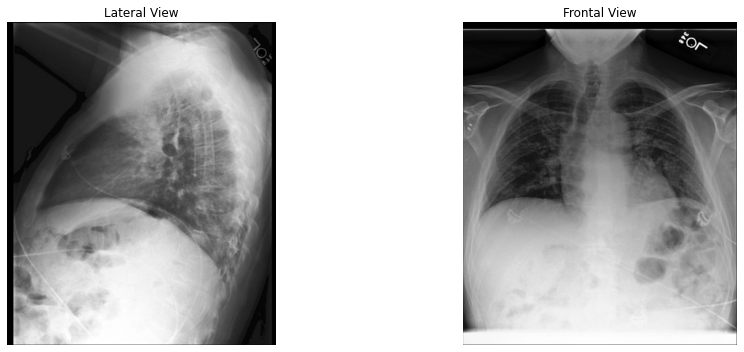


Ground Truth - Findings:
-----------------------------------------------------------------------------------------------------------------------------
Basilar opacity seen on the lateral view best corresponds to a  retrocardiac opacity suspicious for developing left lower
lobe pneumonia or  aspiration event in the setting of altered mental status.  Chronic  peribronchiolar opacities seen
bilaterally are similar in distribution and  slightly more apparent due to lower lung volumes and AP technique.  There is  no
pleural effusion or pneumothorax.  The heart size is normal with normal  cardiomediastinal silhouette.

Ground Truth - Impression:
-----------------------------------------------------------------------------------------------------------------------------
Left lower lobe opacity likely reflects pneumonia or aspiration.

Single-view Model (Frontal) - Findings:
-----------------------------------------------------------------------------------------------------------------------

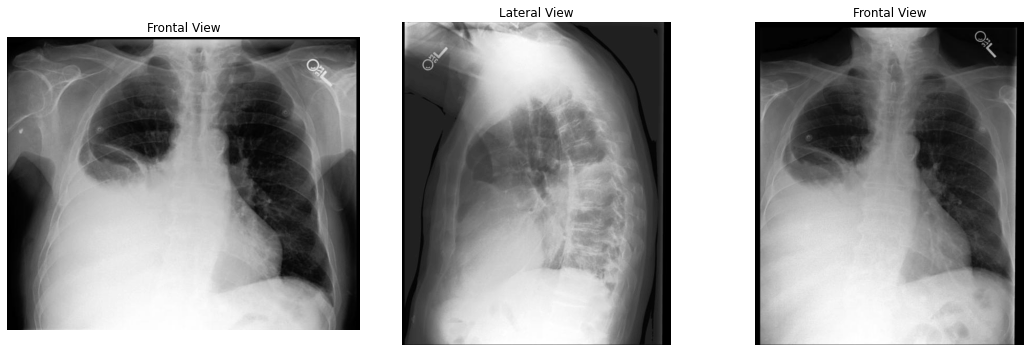


Ground Truth - Findings:
-----------------------------------------------------------------------------------------------------------------------------
Again seen is a large pleural effusion,  with likely a loculated component on the right, with compressive atelectasis  of
major portions of the right lower and middle lobes.  There is no  pneumothorax.  The left lung is well expanded and clear.
The cardiac size is  within normal limits.  The hilar and mediastinal contours are normal.

Ground Truth - Impression:
-----------------------------------------------------------------------------------------------------------------------------
Large right pleural effusion again seen, stable to slightly  increased, likely loculated, with compressive atelectasis of
major portions of  the right middle and lower lobes. If the cause of the pleural effusion has not  been established,
recommended a CT of the chest with contrast, after  thoracentesis to rule out an underlying mass.

Single-view Model (F

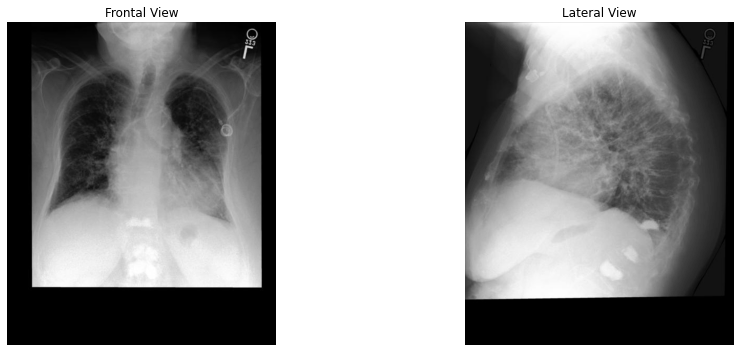


Ground Truth - Findings:
-----------------------------------------------------------------------------------------------------------------------------
Frontal and lateral views of the chest were obtained.  Cardiomegaly is mild,  similar to prior.  Prominent interstitial lung
markings are compatible with  known lung fibrosis.  Indistinct pulmonary vascular markings are similar to  prior and
compatible with mild pulmonary edema.  No focal consolidation,  pleural effusion, or pneumothorax.  The catheter of the left
chest wall port  terminates in the right atrium.  Multiple vertebroplasties are similar to  prior.  No displaced rib fracture
is identified.

Ground Truth - Impression:
-----------------------------------------------------------------------------------------------------------------------------
Mild pulmonary edema superimposed on known lung fibrosis. Severe  chronic cardiomegaly and pulmonary hypertension. No
displaced rib fracture.   Multiple vertebroplasties, similar to prio

In [58]:
compare_models(df_compare_view)

# Load Model from Hugging Face

In [59]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-multi-tf'

# dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True, cache_dir='/working/rajan/multiview-llm/.cache').to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/working/rajan/multiview-llm/envs/cxrmate/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/working/rajan/multiview-llm/envs/cxrmate/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-09-07 14:39:01.716418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07

In [60]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-single-tf'

# dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder_single = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True, cache_dir='/working/rajan/multiview-llm/.cache').to(device)
encoder_decoder_single.eval()
tokenizer_single = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')
image_processor_single = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor_single.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor_single.size['shortest_edge'],
            image_processor_single.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor_single.image_mean,
            std=image_processor_single.image_std,
        ),
    ]
)

/working/rajan/multiview-llm/envs/cxrmate/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Visualisations

## Saliency maps - Multi view

In [386]:
def compute_saliency_map(model, images_tensor, tokenizer):
    model.eval()
    images_tensor = images_tensor.requires_grad_()  # Enable gradient computation

    # Create a dummy target sequence
    dummy_target = torch.zeros((images_tensor.size(0), 1), dtype=torch.long, device=images_tensor.device)
    dummy_target[:, 0] = tokenizer.bos_token_id

    # Forward pass
    outputs = model(
        pixel_values=images_tensor,
        decoder_input_ids=dummy_target,
        return_dict=True
    )

    # Get the score for the most likely next token
    logits = outputs.logits[:, 0, :]  # Get logits for the first position
    scores = torch.nn.functional.log_softmax(logits, dim=-1)
    score = scores.max()  # Get the score for the most likely token

    # Compute gradients
    score.backward()

    # Get the gradients w.r.t the input images
    gradients = images_tensor.grad.data.abs()

    # Take the maximum across color channels
    saliency, _ = torch.max(gradients, dim=-3)
    
    return saliency.cpu().numpy()



def visualize_saliency(images_tensor, images, saliency_maps):
    num_studies, max_images_per_study, _, height, width = images_tensor.shape
    
    for study_idx in range(num_studies):
        num_images = (images_tensor[study_idx, :, 0, 0, 0] != 0).sum().item()
        
        plt.figure(figsize=(5*num_images, 15))
        
        for img_idx in range(num_images):
            actual_image = images[study_idx][img_idx]
            saliency_map = saliency_maps[study_idx, img_idx]
            
            # Normalize saliency map
            saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            
            # Resize saliency map to match the original image size
            saliency_map_resized = Image.fromarray((saliency_map * 255).astype(np.uint8))
            saliency_map_resized = saliency_map_resized.resize(actual_image.size, Image.BICUBIC)
            saliency_map_resized = np.array(saliency_map_resized) / 255.0
            
            plt.subplot(3, num_images, img_idx + 1)
            plt.imshow(actual_image)
            plt.title(f'Original Image {img_idx + 1}')
            plt.axis('off')
            
            plt.subplot(3, num_images, num_images + img_idx + 1)
            plt.imshow(saliency_map, cmap='hot')
            plt.title(f'Saliency Map {img_idx + 1}')
            plt.axis('off')
            
            plt.subplot(3, num_images, 2*num_images + img_idx + 1)
            plt.imshow(actual_image)
            plt.imshow(saliency_map_resized, cmap='hot', alpha=0.5)
            plt.title(f'Overlay {img_idx + 1}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle(f'Study {study_idx + 1}', fontsize=16)
        plt.show()

In [382]:
# Images from study of Patient 1:
image_1 = Image.open(df_compare_view[df_compare_view['study']=='s56031350']['image_path'].iloc[0])
image_1 = image_1.convert('RGB')

image_2 = Image.open(df_compare_view[df_compare_view['study']=='s56031350']['image_path'].iloc[1])
image_2 = image_2.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)

study_a = torch.stack([image_1, image_2], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a], batch_first=True, padding_value=0.0)
images.shape

torch.Size([1, 2, 3, 384, 384])

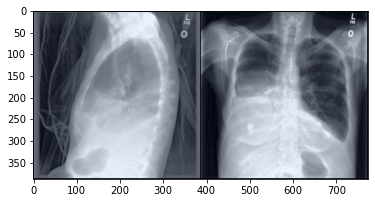

In [383]:
display_images = torch.stack([image_1, image_2], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

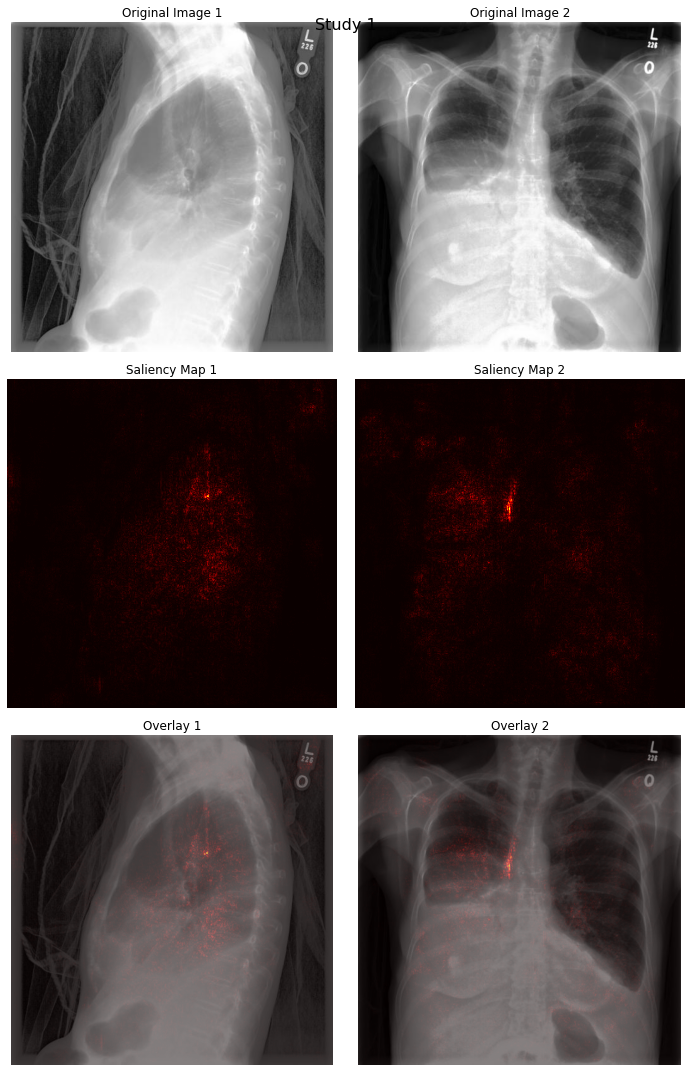

In [387]:
# Main execution
image_1 = Image.open(df_compare_view[df_compare_view['study']=='s56031350']['image_path'].iloc[0])
image_1 = image_1.convert('RGB')
image_2 = Image.open(df_compare_view[df_compare_view['study']=='s56031350']['image_path'].iloc[1])
image_2 = image_2.convert('RGB')
original_images = [[image_1, image_2]]  # List of lists, each sublist represents a study with original images

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
# study_b = torch.stack([image_3], dim=0)
study_a = torch.stack([image_1, image_2], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a], batch_first=True, padding_value=0.0)
images_tensor = images.to(device)  # This is your existing 'images' variable


saliency_maps = compute_saliency_map(encoder_decoder, images_tensor, tokenizer)
visualize_saliency(images_tensor, original_images, saliency_maps)


print_section("Ground Truth - Findings", df_compare_view[df_compare_view['study']=='s56031350']['findings_ground_truth'], 100)
print_section("Ground Truth - Impression", df_compare_view[df_compare_view['study']=='s56031350']['impression_ground_truth'], 100)

print_section("Generated - Findings", df_compare_view[df_compare_view['study']=='s56031350']['findings_multi'], 100)
print_section("Generated - Impression", df_compare_view[df_compare_view['study']=='s56031350']['impression_multi'], 100)

## Single View

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def compute_saliency_map(model, image_tensor, tokenizer):
    model.eval()
    image_tensor = image_tensor.requires_grad_()  # Enable gradient computation

    # Create a dummy target sequence
    dummy_target = torch.zeros((1, 1), dtype=torch.long, device=image_tensor.device)
    dummy_target[0, 0] = tokenizer.bos_token_id

    # Forward pass
    outputs = model(
        pixel_values=image_tensor,
        decoder_input_ids=dummy_target,
        return_dict=True
    )

    # Get the score for the most likely next token
    logits = outputs.logits[:, 0, :]  # Get logits for the first position
    scores = torch.nn.functional.log_softmax(logits, dim=-1)
    score = scores.max()  # Get the score for the most likely token

    # Compute gradients
    score.backward()

    # Get the gradients w.r.t the input image
    gradients = image_tensor.grad.data.abs()

    # Take the maximum across color channels
    saliency, _ = torch.max(gradients, dim=1)

    return saliency.squeeze().cpu().numpy()

def visualize_saliency(original_image, image_tensor, saliency_map):
    plt.figure(figsize=(15, 5))

    # Ensure saliency map is a 2D numpy array
    if isinstance(saliency_map, torch.Tensor):
        saliency_map = saliency_map.cpu().squeeze().numpy()

    # Normalize saliency map
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Resize saliency map to match the original image size
    saliency_map_resized = Image.fromarray((saliency_map * 255).astype(np.uint8))
    saliency_map_resized = saliency_map_resized.resize(original_image.size, Image.BICUBIC)
    saliency_map_resized = np.array(saliency_map_resized) / 255.0

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image)
    plt.imshow(saliency_map_resized, cmap='hot', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()



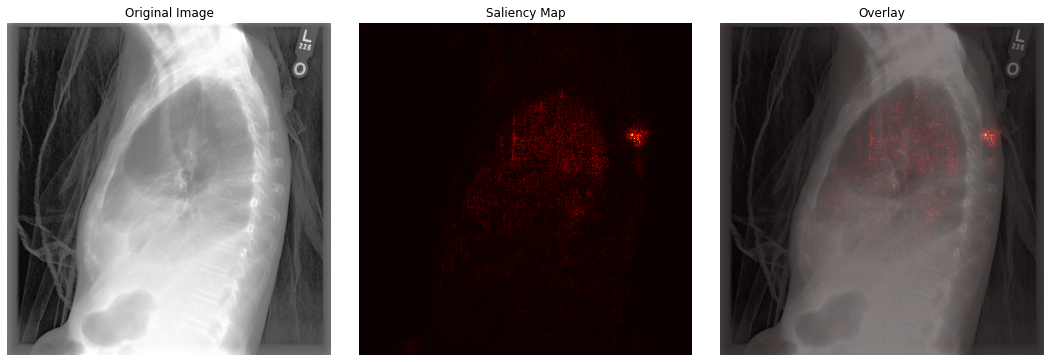

In [390]:
# Main execution
image_1 = Image.open(df_compare_view[df_compare_view['study']=='s56031350']['image_path'].iloc[0])
image_1 = image_1.convert('RGB')
image_1_tensor = test_transforms(image_1)
images_tensor_single = image_1_tensor.unsqueeze(0).to(device)  # Add batch dimension

saliency_maps = compute_saliency_map(encoder_decoder_single, images_tensor_single, tokenizer_single)
visualize_saliency(image_1, image_1_tensor, saliency_maps)

## Attention Map - Single

### Data Loading

In [61]:
import json
import pandas as pd
class RadiopaediaDataset:
    def __init__(self, json_path, base_dir, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)['test']
        self.base_dir = base_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize(size=384 + 64),
            transforms.CenterCrop(size=[384, 384]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        item = self.data[idx]
        images = []
        original_images = []
        for img_path in item['image_path']:
            full_path = os.path.join(self.base_dir, img_path)
            image = Image.open(full_path).convert('RGB')
            original_images.append(image)
            preprocessed_image = self.transform(image)
            images.append(preprocessed_image)
        return torch.stack(images), original_images, item['report'], item['image_path'], item['id']

    def __len__(self):
        return len(self.data)

In [62]:
# Initialize RadiopaediaDataset
dataset = RadiopaediaDataset(
    json_path='/working/rajan/multiview-llm/data/Radiopaedia/radiopaedia_multi.json',
    base_dir='/working/rajan/multiview-llm/data'
)

In [63]:
# load generated reports
# single-view checkpoint outputs
res_single = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/single_tf/trial_0/generated_reports/test_reports_epoch-0_22-08-2024_20-09-07.csv')
res_single = res_single.rename(columns={
    'dicom_id': 'fname'
})

# multi-view checkpoint outputs
res_multi = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/multi_tf/trial_0/generated_reports/test_reports_epoch-0_22-08-2024_20-57-07.csv')

In [64]:
# load radiopaedia dataset
radiopaedia = pd.read_csv('/working/rajan/multiview-llm/data/Radiopaedia/radiopaedia_metadata_sorted.csv')
radiopaedia = radiopaedia.rename(columns={
    'findings': 'gts_findings'
})

res_single = pd.merge(res_single, radiopaedia[['study_id', 'projection', 'gts_findings']], on='study_id')
res_multi = pd.merge(res_multi, radiopaedia[['fname', 'study_id', 'projection', 'gts_findings']], on='study_id')

# CXR-BERT scores
# single-view scores
scores_single = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/single_tf/trial_0/cxr_bert/test_findings_epoch-0_scores_22-08-2024_20-10-00.csv')
scores_single = scores_single.rename(columns={
    'dicom_id': 'fname'
})

# multi-view scores
scores_multi = pd.read_csv('/working/rajan/multiview-llm/Models/Multi/cxrmate/experiments/cxrmate_hf/multi_tf/trial_0/cxr_bert/test_findings_epoch-0_scores_22-08-2024_20-57-58.csv')

# merge scores
single_df = pd.merge(res_single, scores_single[['fname', 'similarity']], on='fname')
multi_df = pd.merge(res_multi, scores_multi[['study_id', 'similarity']], on='study_id')

# compare CXR-BERT results
# Merge the two dataframes on 'study_id' to compare similarities
merged_df = pd.merge(single_df, multi_df, on='study_id', suffixes=('_single', '_multi'), how='inner')

# Filter rows where similarity in 'multi' is greater than in 'single'
higher_similarity_df = merged_df[merged_df['similarity_multi'] > merged_df['similarity_single']]

# significant difference
# Merge the two dataframes on 'study_id' to compare similarities
merged_df = pd.merge(single_df, multi_df, on='study_id', suffixes=('_single', '_multi'))

# Calculate the difference between the 'similarity' scores
merged_df['similarity_difference'] = merged_df['similarity_multi'] - merged_df['similarity_single']

# Filter rows where the difference is greater than 0.4
significant_difference_df = merged_df[merged_df['similarity_difference'] > 0.2]

In [66]:
# Specify the study ID to analyse
target_study_id = 'rID: 35801'

# Get report data for the specific study
report_data = significant_difference_df[significant_difference_df['study_id'] == target_study_id].iloc[0]

# convert to dataframe
report_df = report_data.to_frame().T

# Find the index of the desired study in the dataset
study_index = next((i for i, (_, _, _, _, study_id) in enumerate(dataset) if study_id == target_study_id), None)

if study_index is None:
    raise ValueError(f"Study with ID '{target_study_id}' not found in the dataset.")

# Analyse and visualise
preprocessed_images, original_images, report, image_paths, study_id = dataset[study_index]
print(f"Analyzing Study: {study_id}\n")
print(f"Ground Truth Report: {report}\n")
print(f"Single-view Generated Report: {report_df['findings_single'].iloc[0]}\n")
print(f"Multi-view Generated Report: {report_df['findings_multi'].iloc[0]}\n")

Analyzing Study: rID: 35801

Ground Truth Report: There is consolidation within the postero-inferior aspect of the right upper lobe immediately abutting the horizontal fissure and posterior aspect of the right oblique fissure. No internal cavitation. The remainder of the lungs are clear. No pleural effusions. Heart size is normal. Given the clinical details, this consolidation likely represents infective change. 

Single-view Generated Report: PA and lateral chest views were obtained with patient in upright position. Comparison is made with the next preceding similar study of ___. The heart size is normal. No configurational abnormality is identified. Thoracic aorta unremarkable. No mediastinal abnormalities are seen. The pulmonary vasculature is normal. No signs of acute or chronic parenchymal infiltrates are present and the lateral and posterior pleural sinuses are free. No pneumothorax in apical area on frontal view. Skeletal structures of the thorax grossly within normal limits. Wh

### Raw Attention Map

In [68]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os

def aggregate_attention(attention_maps):
    print(f"Number of attention maps: {len(attention_maps)}")
    print(f"Shape of first attention map: {attention_maps[0].shape}")
    
    # Stack attention maps
    stacked_attention = torch.stack(attention_maps)
    print(f"Shape after stacking: {stacked_attention.shape}")
    
    # Average attention across all layers
    attention = torch.mean(stacked_attention, dim=0)
    print(f"Shape after averaging across layers: {attention.shape}")
    
    # If there are multiple heads, average across them
    if attention.dim() > 2:
        attention = torch.mean(attention, dim=0)
        print(f"Shape after averaging across heads: {attention.shape}")
    
    # Remove any extra dimensions
    attention = attention.squeeze()
    print(f"Final attention shape: {attention.shape}")
    
    # Reshape attention map if necessary
    if attention.dim() == 1:
        # Case for single image: reshape to 2D (assuming square image)
        side_length = int(np.sqrt(attention.shape[0]))
        attention = attention.view(side_length, side_length)
    
    print(f"Reshaped attention shape: {attention.shape}")
    return attention

def visualize_attention_overlay(original_image, attention, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
    
    # Ensure original_image is a PIL Image
    if isinstance(original_image, torch.Tensor):
        original_image = to_pil_image(original_image)
    
    # Resize attention map to match original image size
    attention = attention.detach().cpu().numpy()
    attention = Image.fromarray(attention).resize(original_image.size, Image.BILINEAR)
    attention = np.array(attention)
    
    # Normalize attention to [0, 1]
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    
    # Create a color map
    cmap = plt.get_cmap('jet')
    attention_color = cmap(attention)
    attention_color[:,:,3] = 0.6  # Set alpha for overlay
    
    # Display the original image
    ax.imshow(original_image, cmap='gray')
    
    # Overlay the attention map
    ax.imshow(attention_color, alpha=0.5)
    ax.axis('off')
    return ax

def visualize_single_view_attention(original_image, attention_maps, save_path='/working/rajan/multiview-llm/Model Analysis/figures/single_attn_cxrmate.png'):
    aggregated_attention = aggregate_attention(attention_maps)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    visualize_attention_overlay(original_image, aggregated_attention, ax)
    
    # Add a title for the image
    ax.set_title("Single Image", fontsize=45, fontweight='bold')
    
    # # Add a larger title for the entire figure
    # fig.suptitle("Attention Map Visualization", fontsize=40, fontweight='bold', y=1.05)
    
    plt.tight_layout()

    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='white')
    plt.show()
    
    return aggregated_attention

In [69]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-single-tf'

# dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder_single = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True, cache_dir='/working/rajan/multiview-llm/.cache').to(device)
encoder_decoder_single.eval()
tokenizer_single = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')
image_processor_single = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor_single.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor_single.size['shortest_edge'],
            image_processor_single.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor_single.image_mean,
            std=image_processor_single.image_std,
        ),
    ]
)

/working/rajan/multiview-llm/envs/cxrmate/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/working/rajan/multiview-llm/envs/cxrmate/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [70]:
# Main execution
# Check and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure the model is on the correct device
encoder_decoder_single = encoder_decoder_single.to(device)

# Prepare the input
base_dir = '/working/rajan/multiview-llm/data'
full_path = os.path.join(base_dir, image_paths[0])
original_image = Image.open(full_path).convert('RGB')
images_tensor = test_transforms(original_image).unsqueeze(0).to(device)  # Move to the same device as the model

# Create a dummy target sequence
dummy_target = torch.zeros((images_tensor.size(0), 1), dtype=torch.long, device=device)
dummy_target[:, 0] = tokenizer_single.bos_token_id

# Set the model to evaluation mode
encoder_decoder_single.eval()

# Get model outputs
with torch.no_grad():
    outputs = encoder_decoder_single(
        pixel_values=images_tensor,
        decoder_input_ids=dummy_target,
        output_attentions=True,
        return_dict=True
    )

# Extract cross-attentions
cross_attentions = outputs.cross_attentions
print(f"Number of cross-attention layers: {len(cross_attentions)}")
print(f"Shape of first cross-attention layer: {cross_attentions[0].shape}")

# Process cross-attentions
attention_maps = []
for i, layer_attention in enumerate(cross_attentions):
    print(f"Processing layer {i}, shape: {layer_attention.shape}")
    # Average over heads and target sequence (which is just 1 in this case)
    attention_map = layer_attention.mean(dim=(1, 2)).squeeze()
    attention_maps.append(attention_map)
    print(f"Processed attention map shape: {attention_map.shape}")


Using device: cuda
Number of cross-attention layers: 6
Shape of first cross-attention layer: torch.Size([1, 12, 1, 576])
Processing layer 0, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])
Processing layer 1, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])
Processing layer 2, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])
Processing layer 3, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])
Processing layer 4, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])
Processing layer 5, shape: torch.Size([1, 12, 1, 576])
Processed attention map shape: torch.Size([576])


Number of attention maps: 6
Shape of first attention map: torch.Size([576])
Shape after stacking: torch.Size([6, 576])
Shape after averaging across layers: torch.Size([576])
Final attention shape: torch.Size([576])
Reshaped attention shape: torch.Size([24, 24])
Number of attention maps: 6
Shape of first attention map: torch.Size([576])
Shape after stacking: torch.Size([6, 576])
Shape after averaging across layers: torch.Size([576])
Final attention shape: torch.Size([576])
Reshaped attention shape: torch.Size([24, 24])


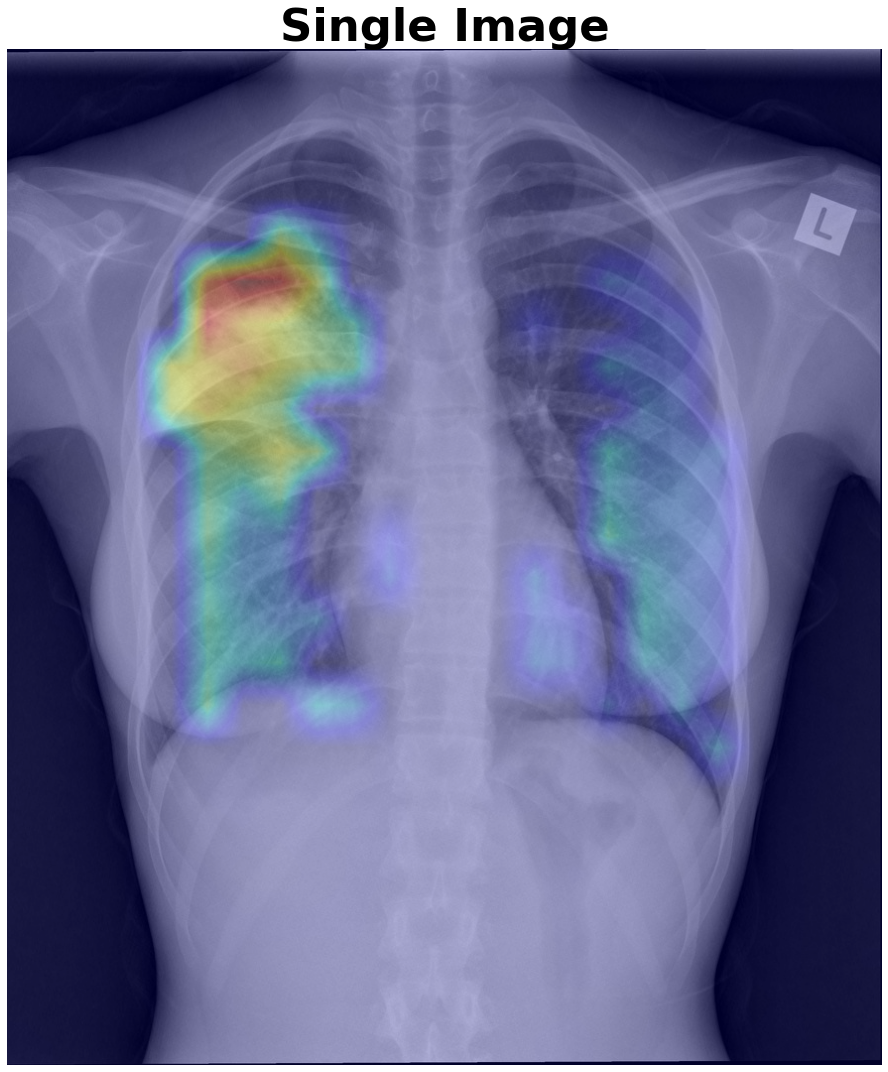

Final aggregated attention shape: torch.Size([24, 24])


In [71]:
# Aggregate and visualise attention map
aggregated_attention = aggregate_attention(attention_maps)

# Visualise attention map
visualize_single_view_attention(original_image, attention_maps)

print(f"Final aggregated attention shape: {aggregated_attention.shape}")

## Attention Map - Multi

In [72]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-multi-tf'

# dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True, cache_dir='/working/rajan/multiview-llm/.cache').to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name, cache_dir='/working/rajan/multiview-llm/.cache')

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

In [73]:
# Specify the study ID to analyse
target_study_id = 'rID: 35801'
# Get report data for the specific study
report_data = significant_difference_df[significant_difference_df['study_id'] == target_study_id].iloc[0]

# convert to dataframe
report_df = report_data.to_frame().T

# Find the index of the desired study in the dataset
study_index = next((i for i, (_, _, _, _, study_id) in enumerate(dataset) if study_id == target_study_id), None)

if study_index is None:
    raise ValueError(f"Study with ID '{target_study_id}' not found in the dataset.")

# Analyse and visualize
preprocessed_images, original_images, report, image_paths, study_id = dataset[study_index]
print(f"Analyzing Study: {study_id}\n")
print(f"Ground Truth Report: {report}\n")
print(f"Single-view Generated Report: {report_df['findings_single'].iloc[0]}\n")
print(f"Multi-view Generated Report: {report_df['findings_multi'].iloc[0]}\n")

Analyzing Study: rID: 35801

Ground Truth Report: There is consolidation within the postero-inferior aspect of the right upper lobe immediately abutting the horizontal fissure and posterior aspect of the right oblique fissure. No internal cavitation. The remainder of the lungs are clear. No pleural effusions. Heart size is normal. Given the clinical details, this consolidation likely represents infective change. 

Single-view Generated Report: PA and lateral chest views were obtained with patient in upright position. Comparison is made with the next preceding similar study of ___. The heart size is normal. No configurational abnormality is identified. Thoracic aorta unremarkable. No mediastinal abnormalities are seen. The pulmonary vasculature is normal. No signs of acute or chronic parenchymal infiltrates are present and the lateral and posterior pleural sinuses are free. No pneumothorax in apical area on frontal view. Skeletal structures of the thorax grossly within normal limits. Wh

In [74]:
# Check and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure the model is on the correct device
encoder_decoder = encoder_decoder.to(device)

# Prepare the input
base_dir = '/working/rajan/multiview-llm/data'
original_images = []
processed_images = []

for path in image_paths:
    full_path = os.path.join(base_dir, path)
    original_image = Image.open(full_path).convert('RGB')
    original_images.append(original_image)
    
    processed_image = test_transforms(original_image)
    processed_images.append(processed_image)

study_a = torch.stack(processed_images, dim=0)
images = torch.nn.utils.rnn.pad_sequence([study_a], batch_first=True, padding_value=0.0)
images_tensor = images.to(device)

# Create a dummy target sequence
dummy_target = torch.zeros((images_tensor.size(0), 1), dtype=torch.long, device=device)
dummy_target[:, 0] = tokenizer.bos_token_id


Using device: cuda


In [75]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

def aggregate_attention(attention_maps):
    print(f"Number of attention maps: {len(attention_maps)}")
    print(f"Shape of first attention map: {attention_maps[0].shape}")
    
    # Stack attention maps
    stacked_attention = torch.stack(attention_maps)
    print(f"Shape after stacking: {stacked_attention.shape}")
    
    # Average attention across all layers
    attention = torch.mean(stacked_attention, dim=0)
    print(f"Shape after averaging across layers: {attention.shape}")
    
    # If there are multiple heads, average across them
    if attention.dim() > 2:
        attention = torch.mean(attention, dim=0)
        print(f"Shape after averaging across heads: {attention.shape}")
    
    # Remove any extra dimensions
    attention = attention.squeeze()
    print(f"Final attention shape: {attention.shape}")
    
    # Reshape attention map if necessary
    if attention.dim() == 1:
        # Case for multiple images: reshape to 2D 
        num_pixels = attention.shape[0]
        num_images = 2  # Assuming two images
        side_length = int(np.sqrt(num_pixels / num_images))
        attention = attention.view(num_images, side_length, side_length)
    elif attention.dim() == 2:
        # Case for single image: no need to reshape
        pass
    
    print(f"Reshaped attention shape: {attention.shape}")
    return attention

def visualize_attention_overlay(original_image, attention, ax=None, add_colorbar=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Ensure original_image is a PIL Image
    if isinstance(original_image, torch.Tensor):
        original_image = to_pil_image(original_image)
    
    # Resize attention map to match original image size
    attention = attention.detach().cpu().numpy()
    attention = Image.fromarray(attention).resize(original_image.size, Image.BILINEAR)
    attention = np.array(attention)
    
    # Normalize attention to [0, 1]
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    
    # Create a color map
    cmap = plt.get_cmap('jet')
    attention_color = cmap(attention)
    attention_color[:,:,3] = 0.6  # Set alpha for overlay
    
    # Display the original image
    ax.imshow(original_image, cmap='gray')
    
    # Overlay the attention map
    im = ax.imshow(attention_color, alpha=0.5)
    ax.axis('off')
    
    # if add_colorbar:
    #     divider = make_axes_locatable(ax)
    #     cax = divider.append_axes("right", size="5%", pad=0.05)
    #     cbar = plt.colorbar(im, cax=cax)
    #     cbar.ax.tick_params(labelsize=35)
    
    return ax

def visualize_attention_maps(original_images, processed_images, attention_maps, save_path='/working/rajan/multiview-llm/Model Analysis/figures/multi_attn_cxrmate.png'):
    aggregated_attention = aggregate_attention(attention_maps)
    num_images = len(original_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15*num_images, 15))
    if num_images == 1:
        axes = [axes]
    
    print(f"aggregate_attention dimensions: {aggregated_attention.dim()}")
    
    for i, ax in enumerate(axes):
        visualize_attention_overlay(
            original_images[i],
            aggregated_attention[i] if aggregated_attention.dim() == 3 else aggregated_attention,
            ax,
            add_colorbar=(i == num_images - 1)  # Add colorbar only to the last image
        )
        ax.set_title(f"Image {i+1}", fontsize=45, fontweight='bold')

        
    # Adjust layout to align images at the top
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust these values as needed
    
    plt.tight_layout()

    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='white')
    plt.show()
    
    return aggregated_attention

# Set global font sizes
plt.rcParams.update({'font.size': 16})

In [76]:
# Set the model to evaluation mode
encoder_decoder.eval()

# Try to get model outputs
with torch.no_grad():
    outputs = encoder_decoder(
        pixel_values=images_tensor,
        decoder_input_ids=dummy_target,
        output_attentions=True,
        return_dict=True
    )

# Extract cross-attentions
cross_attentions = outputs.cross_attentions
print(f"Number of cross-attention layers: {len(cross_attentions)}")
print(f"Shape of first cross-attention layer: {cross_attentions[0].shape}")

# Process cross-attentions
attention_maps = []
for i, layer_attention in enumerate(cross_attentions):
    print(f"Processing layer {i}, shape: {layer_attention.shape}")
    # Average over heads and target sequence (which is just 1 in this case)
    attention_map = layer_attention.mean(dim=(1, 2)).squeeze()
    attention_maps.append(attention_map)
    print(f"Processed attention map shape: {attention_map.shape}")

Number of cross-attention layers: 6
Shape of first cross-attention layer: torch.Size([1, 12, 1, 1152])
Processing layer 0, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])
Processing layer 1, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])
Processing layer 2, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])
Processing layer 3, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])
Processing layer 4, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])
Processing layer 5, shape: torch.Size([1, 12, 1, 1152])
Processed attention map shape: torch.Size([1152])


Number of attention maps: 6
Shape of first attention map: torch.Size([1152])
Shape after stacking: torch.Size([6, 1152])
Shape after averaging across layers: torch.Size([1152])
Final attention shape: torch.Size([1152])
Reshaped attention shape: torch.Size([2, 24, 24])
aggregate_attention dimensions: 3


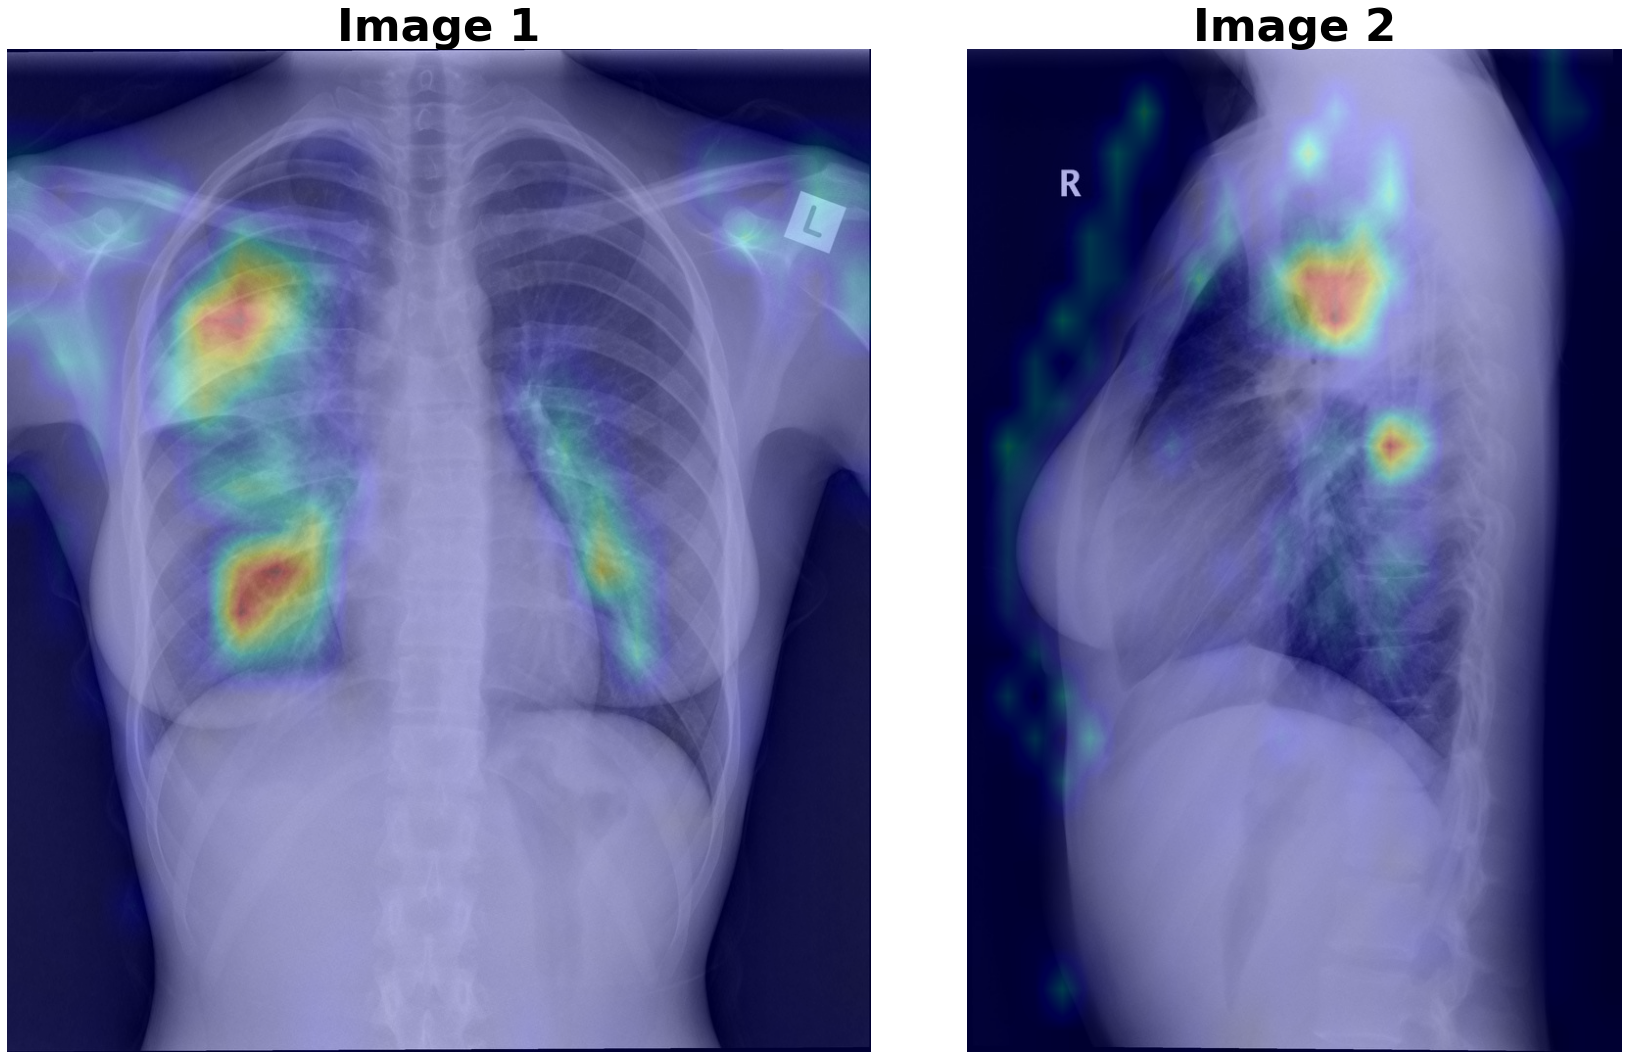

Final aggregated attention shape: torch.Size([2, 24, 24])


In [78]:
# Visualise attention maps
aggregated_attention = visualize_attention_maps(original_images, images_tensor.squeeze(0), attention_maps)

print(f"Final aggregated attention shape: {aggregated_attention.shape}")